# Segmenting and Clustering Neighborhoods in Toronto

## First part : Web scraping with beautiful soup

In [30]:
from bs4 import BeautifulSoup as BS
from requests import get
import pandas as pd
from geopy.geocoders import Nominatim
import folium
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [3]:
page_brute = get(url=url)
texte = page_brute.text

In [4]:
soupe = BS(texte, "lxml")

In [5]:
table = soupe.find_all(attrs = {"class" : "wikitable"})


In [6]:
corps = table[0].find_next(name="tbody")

In [7]:
titres, *lignes = corps.find_all(name="tr")

In [8]:
def main(url):
    
    page_brute = get(url=url)
    texte = page_brute.text
    soupe = BS(texte, "lxml")
    balises_tables = soupe.find_all(name="table", attrs={"class" : "wikitable"})
    
    corps = balises_tables[0].find_next(name="tbody")
    
    titres, *lignes = corps.find_all(name="tr")   
    
    table_liste = [gestion_ligne(ma_ligne) for ma_ligne in lignes]
    
    liste_titres = titres.find_all("th")
    
    titres_clean = [i.text.strip() for i in liste_titres]
        
    table = pd.DataFrame(table_liste, columns = titres_clean)
    
    
    return table    

In [9]:
def gestion_ligne(balise_tr):
    nom, secteurs, poids_indiciel=balise_tr.find_all(name="td")
    return [
        nom.text.strip(),
        secteurs.text.strip(),
        poids_indiciel.text.strip()
    ]

In [10]:
table = main(url)

In [11]:
table_clean = table[table["Borough"] != "Not assigned"]

## Cleaning table

In [12]:
table_clean

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [13]:
table_clean.shape

(103, 3)

## Second part : adding location data

In [14]:
coord = pd.read_csv("Geospatial_Coordinates.csv")

In [15]:
coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [16]:
table_full = pd.merge(table_clean, coord, on='Postal Code')

In [17]:
table_full

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [18]:
table_toronto = table_full[table_full["Borough"].str.contains('toronto',case=False)]

In [19]:
table_toronto

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
31,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


## Building the map

In [20]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [21]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(table_toronto['Latitude'], table_toronto['Longitude'], table_toronto['Borough'], table_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Clustering
### Cleaning the data

In [22]:
toronto_clustering = table_toronto.drop(['Postal Code','Borough','Neighbourhood'],1)

We have to determine the best number of clusters K, we will compute the Elbow method and the silhouette method

In [23]:
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(toronto_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(toronto_clustering, labels, metric = 'euclidean'))

In [24]:
sil

[0.3605839712691018,
 0.4394530089377052,
 0.5121448889288607,
 0.4740744833836112,
 0.4237857972503876,
 0.3951428775664045,
 0.36813020306037425,
 0.34122671562966556,
 0.39983783551974295]

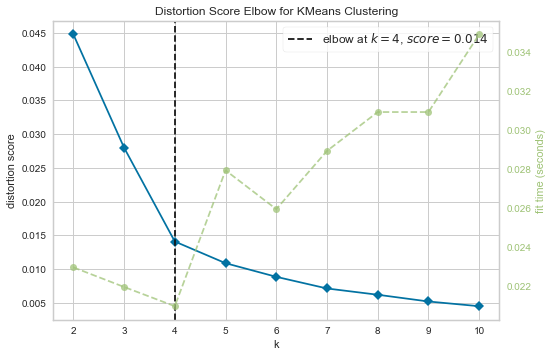

In [25]:
model = KElbowVisualizer(KMeans(), k=10)
model.fit(toronto_clustering)
model.show()

For the silhouette method, the optimal number of cluters is 3 and for the Elbow method it is 4. Thus, we have to make a choice, then, we notice that the silhouette statistic for K = 3 is not really far from the K = 4, so we can choose the K = 4 clusters.

In [36]:
k=4
kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)
kmeans.labels_
table_toronto.insert(0, 'Cluster Labels', kmeans.labels_)

In [37]:
table_toronto

,Cluster Labels,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,0,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,0,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,0,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,3,M4E,East Toronto,The Beaches,43.676357,-79.293031
20,0,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
24,0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
25,1,M6G,Downtown Toronto,Christie,43.669542,-79.422564
30,0,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
31,1,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


In [39]:
map_toronto_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(table_toronto['Latitude'], table_toronto['Longitude'], table_toronto['Neighbourhood'], table_toronto['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto_clusters)
       
map_toronto_clusters